In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt

#importing packages for the prediction of time-series data
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [8]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [10]:
df = pd.read_csv('COCO COLA.csv', parse_dates=['Date'])
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800


In [13]:
print (df.describe())
print ("=============================================================")
print (df.dtypes)

                                Date          Open          High  \
count                          15096  15096.000000  15096.000000   
mean   1992-01-04 11:35:29.093799680     16.056202     16.188428   
min              1962-01-02 00:00:00      0.192708      0.193359   
25%              1977-01-26 18:00:00      0.860677      0.869792   
50%              1992-01-02 12:00:00      9.328125      9.398438   
75%              2006-12-20 06:00:00     28.875000     29.167500   
max              2021-12-17 00:00:00     59.810001     60.130001   
std                              NaN     16.939301     17.064336   

                Low         Close     Adj Close        Volume  
count  15096.000000  15096.000000  15096.000000  1.509600e+04  
mean      15.921876     16.060734     11.367487  9.032904e+06  
min        0.182292      0.192057      0.037855  7.680000e+04  
25%        0.854167      0.860352      0.242312  2.812800e+06  
50%        9.218750      9.351562      4.642848  7.585200e+06  
75%

In [15]:
df1 = df[['Date','Close']]
df1.head(3)

,Date,Close
0,1962-01-02,0.263021
1,1962-01-03,0.257161
2,1962-01-04,0.259115


In [17]:
# Setting the Date as Index
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
print (type(df_ts))
print (df_ts.head(3))
print ("========================")
print (df_ts.tail(3))

<class 'pandas.core.frame.DataFrame'>
               Close
Date                
1962-01-02  0.263021
1962-01-03  0.257161
1962-01-04  0.259115
                Close
Date                 
2021-12-15  58.060001
2021-12-16  58.650002
2021-12-17  57.730000


In [19]:
# Basic plot 
df_ts.plot()

<Axes: xlabel='Date'>

In [21]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)
    

In [23]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test 
# Convert the DF to series first
ts = df_ts['Close']

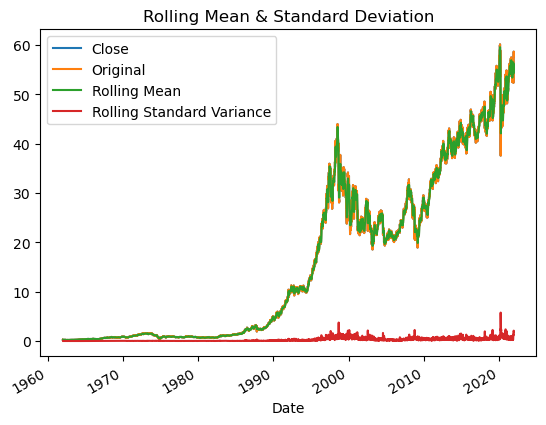

In [25]:
# Let's plot the 12-Month Moving Rolling Mean & Variance and find Insights
# Rolling Statistics
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()

plt.plot(ts, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolvar, label='Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [27]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                     0.527771
p-value                            0.985693
#lags Used                        43.000000
Number of Observations Used    15052.000000
Critical Value (1%)               -3.430785
Critical Value (5%)               -2.861732
Critical Value (10%)              -2.566872
dtype: float64


In [28]:
# Lets Resample the data by Month and analyze again
df_ts_m = df_ts.resample('M').mean()
print (type(df_ts_m))
print (df_ts_m.head(3))

<class 'pandas.core.frame.DataFrame'>
               Close
Date                
1962-01-31  0.247692
1962-02-28  0.243318
1962-03-31  0.245517


In [29]:
tsm = df_ts_m['Close']
print (type(tsm))

<class 'pandas.core.series.Series'>


In [33]:
# Stationarity Check
test_stationarity(tsm)

Results of Dickey-Fuller Test:
Test Statistic                   0.789563
p-value                          0.991466
#lags Used                      18.000000
Number of Observations Used    701.000000
Critical Value (1%)             -3.439713
Critical Value (5%)             -2.865672
Critical Value (10%)            -2.568970
dtype: float64


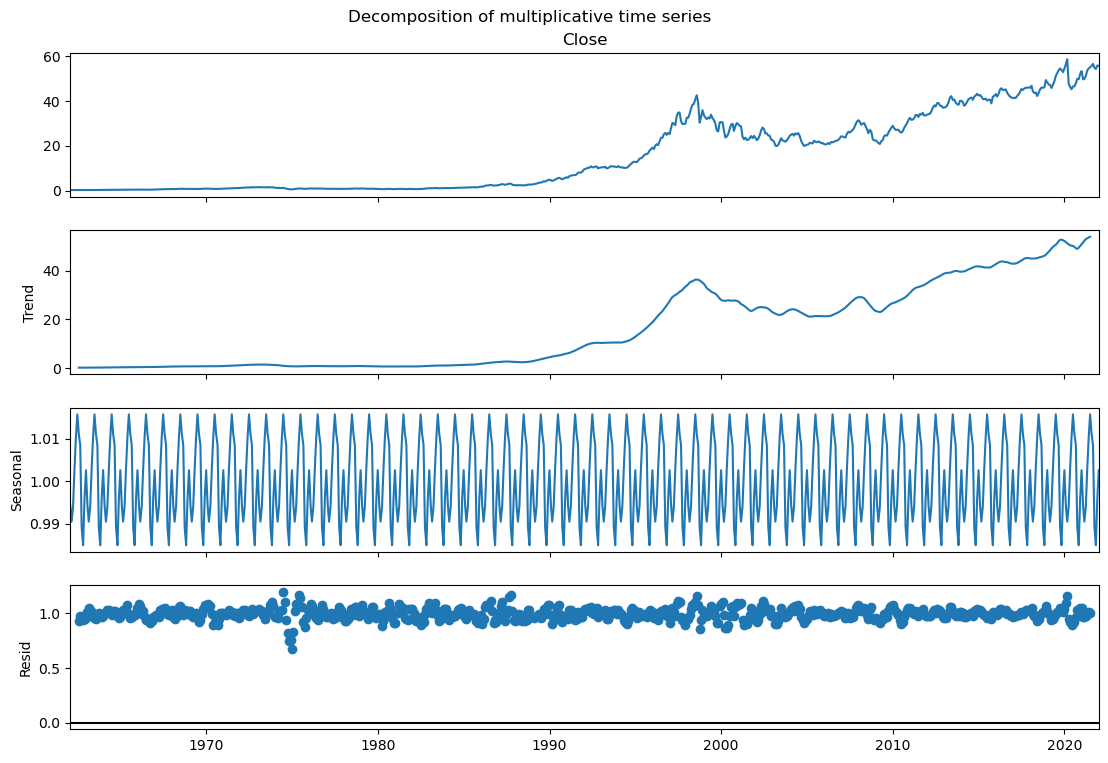

In [35]:
# Lets do a quick vanila decomposition to see any trend seasonality etc in the ts
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [36]:
# lets try to make the "tsm" Stationary

tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
# Stationarity Check
test_stationarity(tsmlogdiff)

Results of Dickey-Fuller Test:
Test Statistic                -1.800432e+01
p-value                        2.727719e-30
#lags Used                     1.000000e+00
Number of Observations Used    7.170000e+02
Critical Value (1%)           -3.439503e+00
Critical Value (5%)           -2.865579e+00
Critical Value (10%)          -2.568921e+00
dtype: float64


In [39]:
# Let's plot ACF & PACF graphs to visualize AR & MA components

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

# EDA

year 2019

In [43]:
y_2019 = df.loc[(df['Date'] >= '2019-01-01')
                     & (df['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
14348,2019-01-02,46.939999,47.220001,46.560001,46.930000
14349,2019-01-03,46.820000,47.369999,46.529999,46.639999
14350,2019-01-04,46.750000,47.570000,46.639999,47.570000
14351,2019-01-07,47.570000,47.750000,46.900002,46.950001
14352,2019-01-08,47.250000,47.570000,47.040001,47.480000
...,...,...,...,...,...
14595,2019-12-24,54.799999,55.000000,54.639999,54.709999
14596,2019-12-26,54.919998,55.020000,54.790001,55.020000
14597,2019-12-27,55.009998,55.450001,55.000000,55.349998
14598,2019-12-30,55.180000,55.389999,55.060001,55.270000


In [45]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,47.290476,47.355714
February,47.209473,47.171579
March,45.768572,45.824286
April,47.172381,47.219524
May,48.715909,48.770909
June,51.122000,51.154000
July,52.492727,52.460909
August,53.671818,53.722728
September,54.587500,54.554500


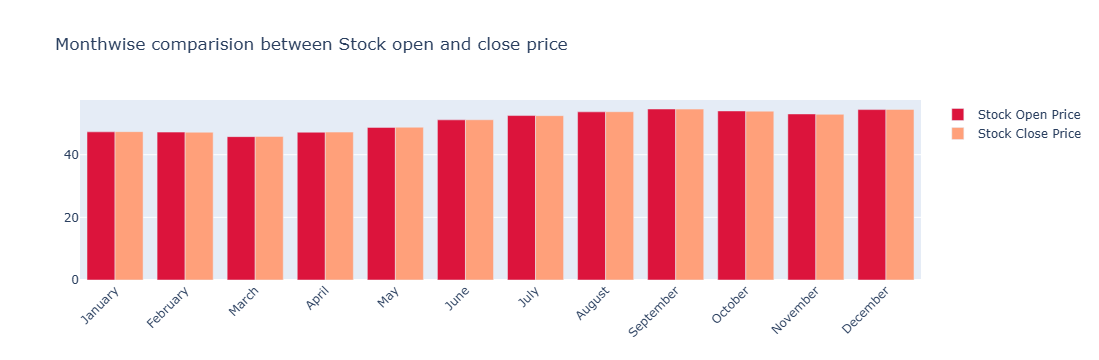

In [47]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

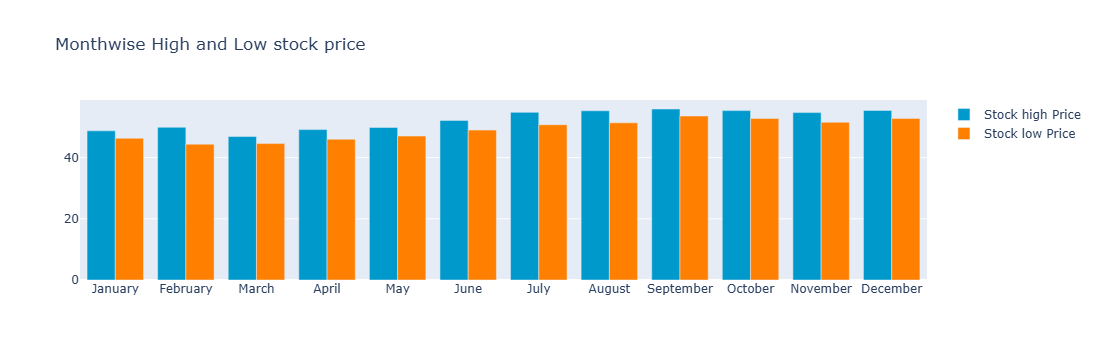

In [49]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [51]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()